# Endometriosis Detection

### 1. Exploring the dataset

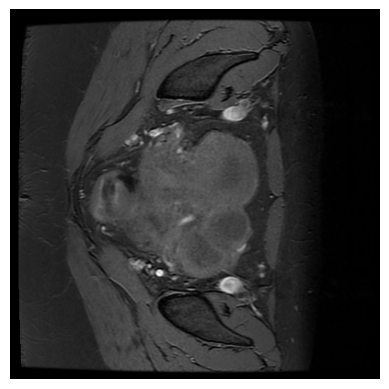

In [7]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img=nib.load("UT-EndoMRI/D1_MHS/D1-000/D1-000_T1FS.nii.gz")
imgdata=img.get_fdata()

slice_index = imgdata.shape[2] // 2
plt.imshow(imgdata[:, :, slice_index], cmap="gray")
plt.axis("off")
plt.show()

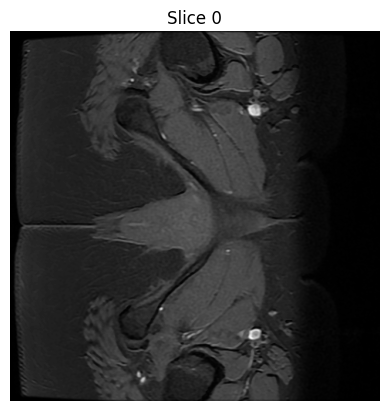

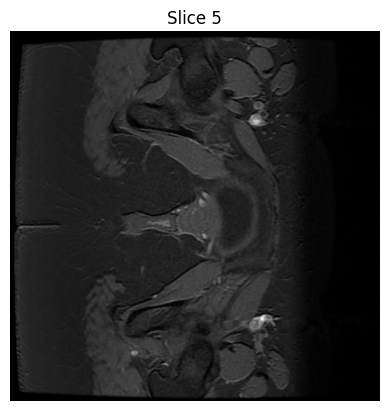

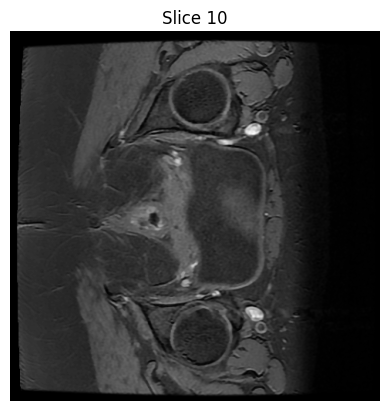

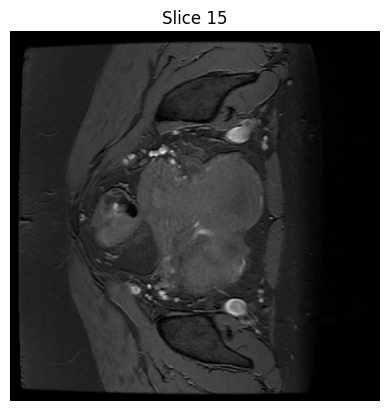

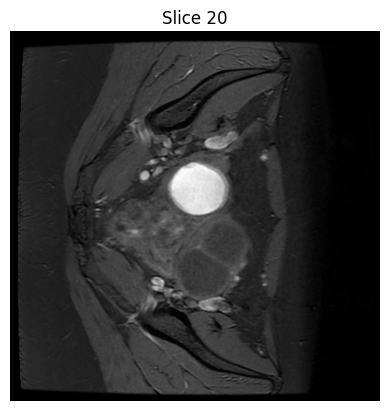

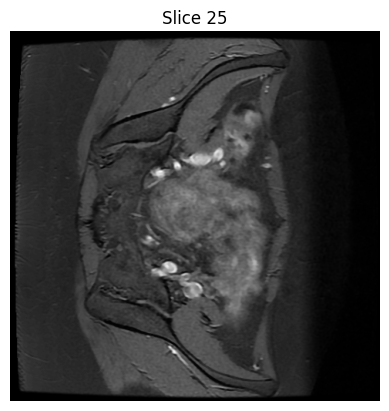

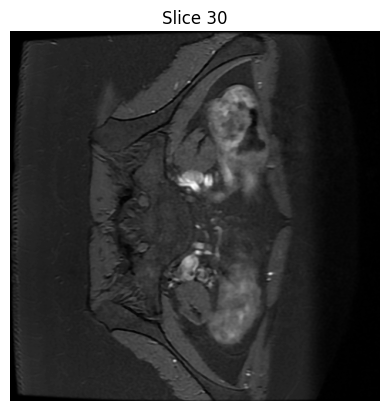

In [8]:
for i in range(0, imgdata.shape[2], 5):  # step of 5 slices
    plt.imshow(imgdata[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

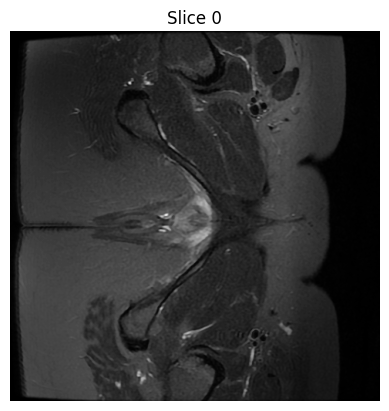

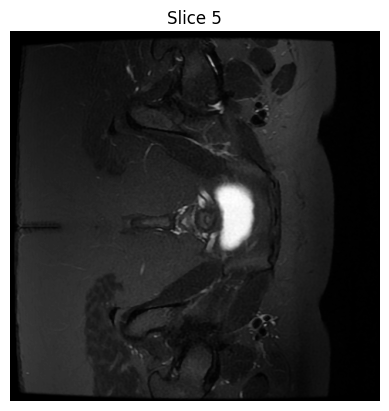

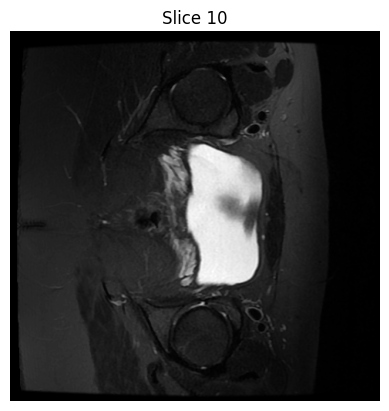

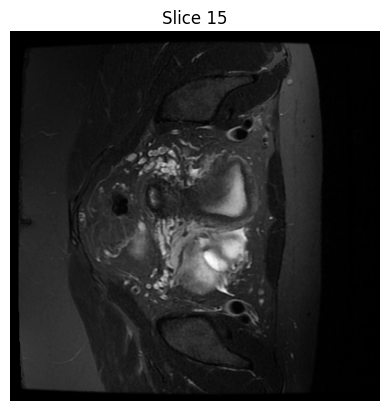

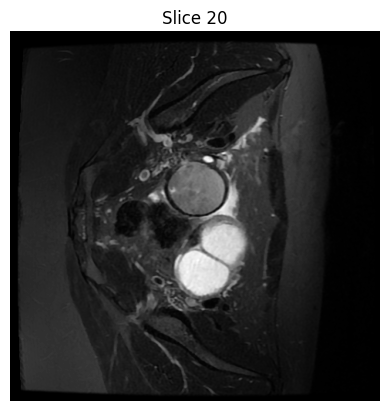

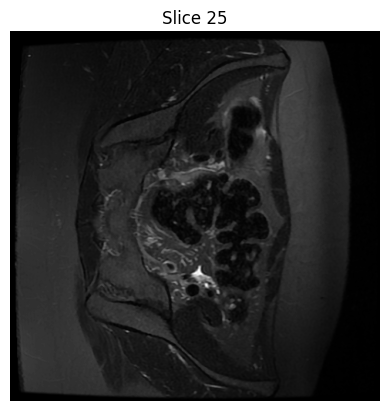

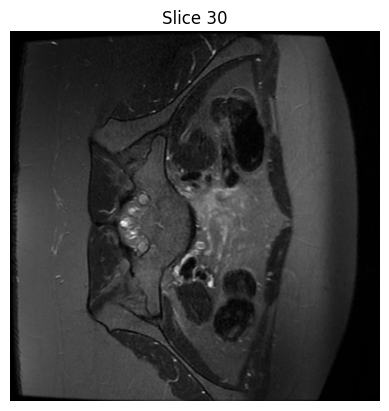

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img=nib.load("UT-EndoMRI/D1_MHS/D1-000/D1-000_T2.nii.gz")
imgdata=img.get_fdata()

for i in range(0, imgdata.shape[2], 5):  # step of 5 slices
    plt.imshow(imgdata[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

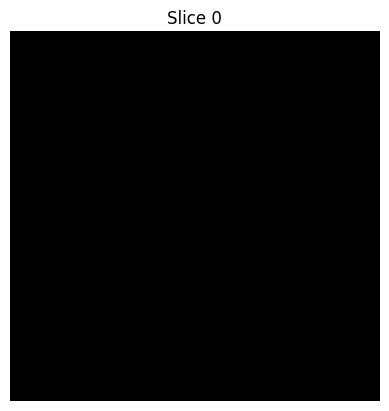

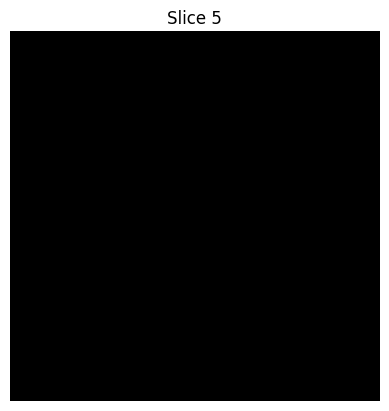

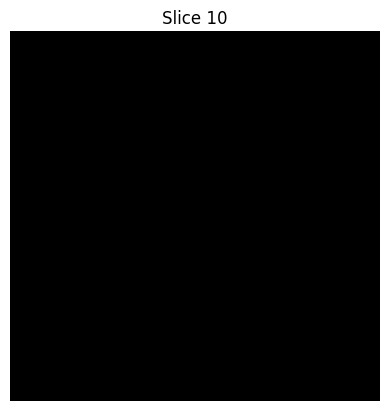

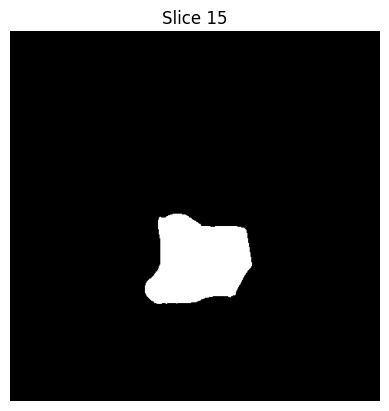

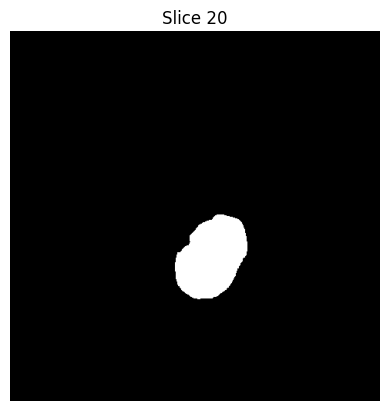

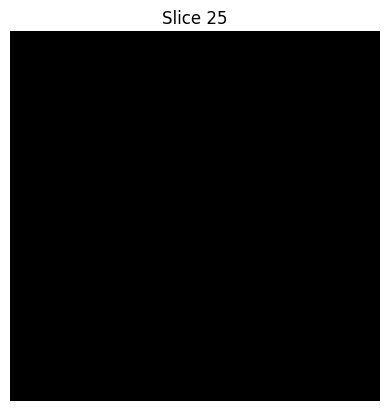

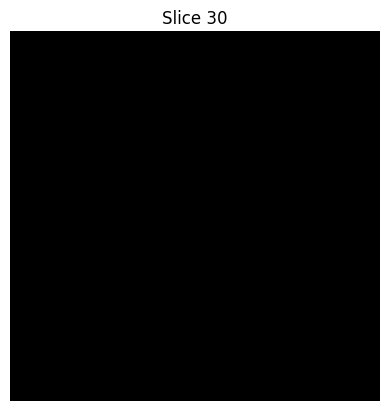

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img=nib.load("UT-EndoMRI/D1_MHS/D1-000/D1-000_ov_r1.nii.gz")
imgdata=img.get_fdata()

for i in range(0, imgdata.shape[2], 5):  # step of 5 slices
    plt.imshow(imgdata[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

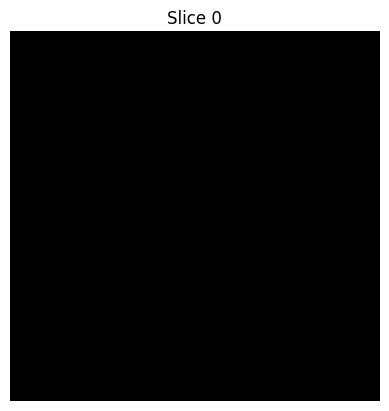

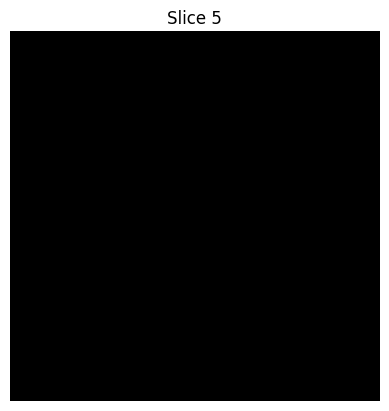

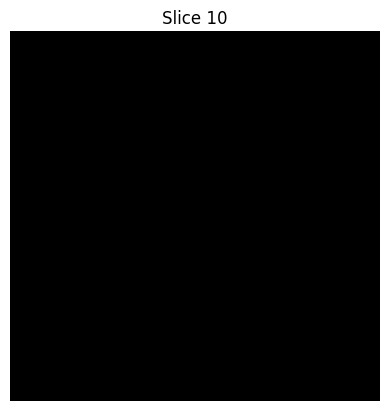

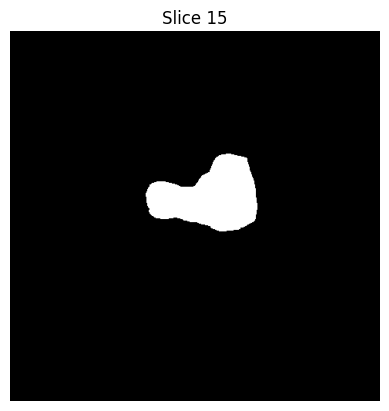

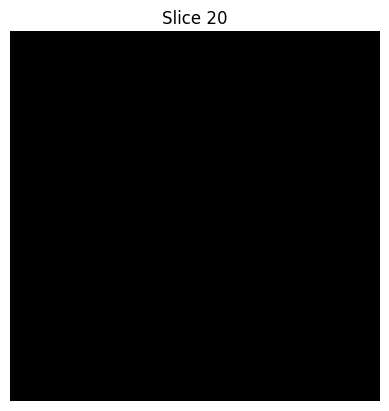

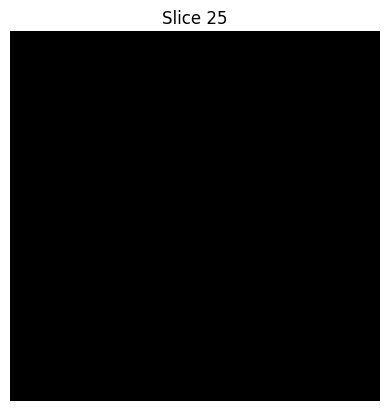

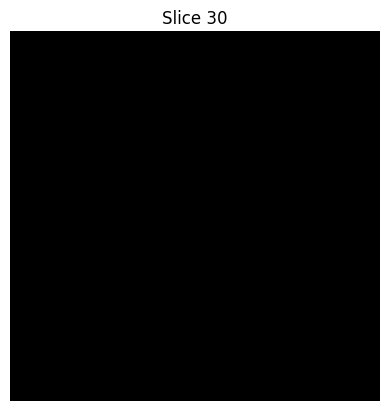

In [3]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img=nib.load("UT-EndoMRI/D1_MHS/D1-000/D1-000_ut_r1.nii.gz")
imgdata=img.get_fdata()

for i in range(0, imgdata.shape[2], 5):  # step of 5 slices
    plt.imshow(imgdata[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

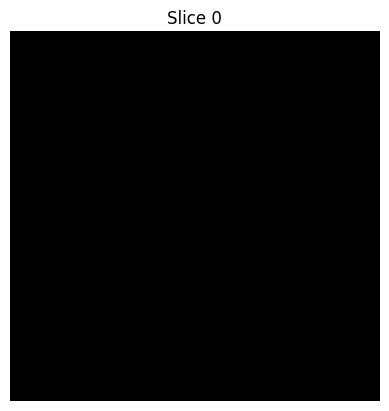

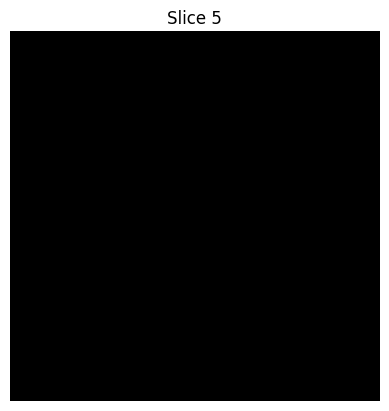

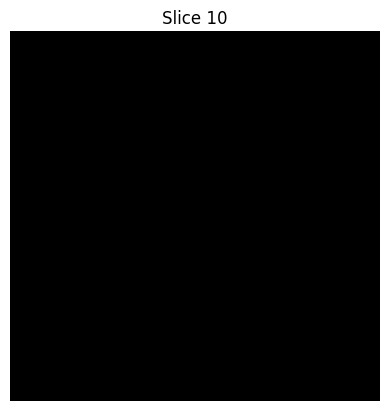

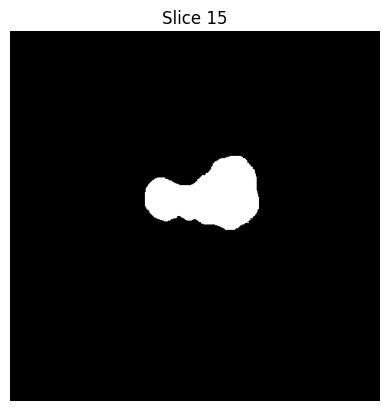

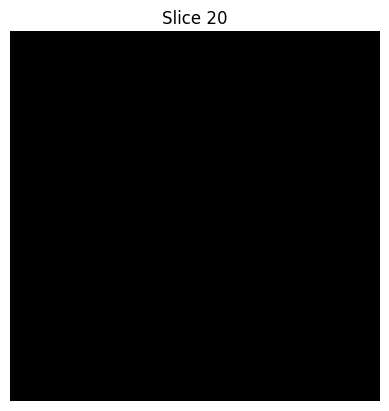

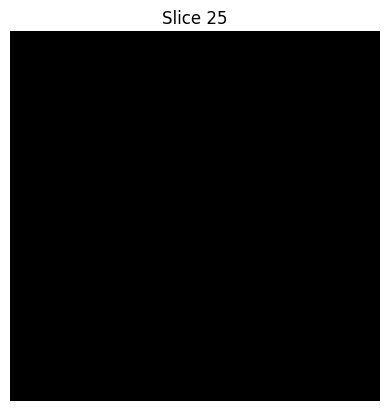

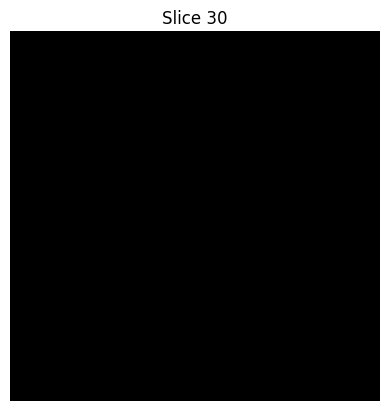

In [4]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img=nib.load("UT-EndoMRI/D1_MHS/D1-000/D1-000_ut_r2.nii.gz")
imgdata=img.get_fdata()

for i in range(0, imgdata.shape[2], 5):  # step of 5 slices
    plt.imshow(imgdata[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

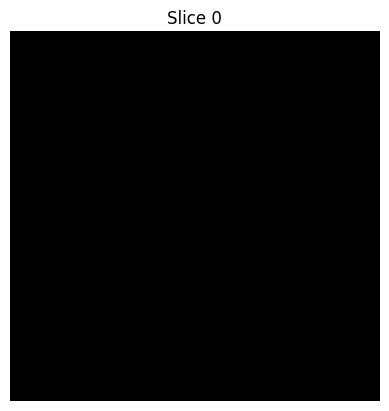

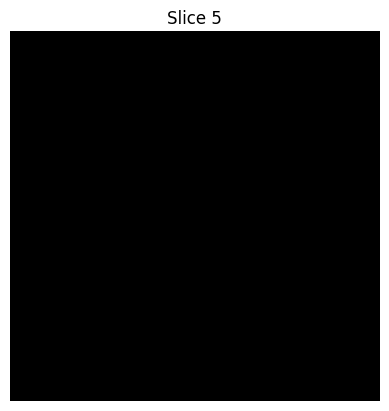

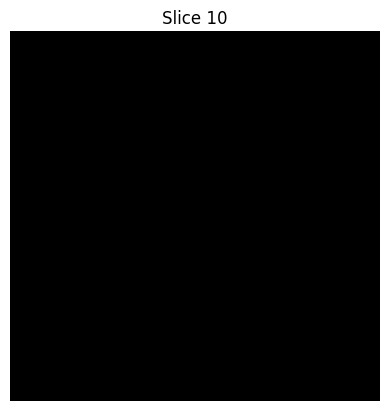

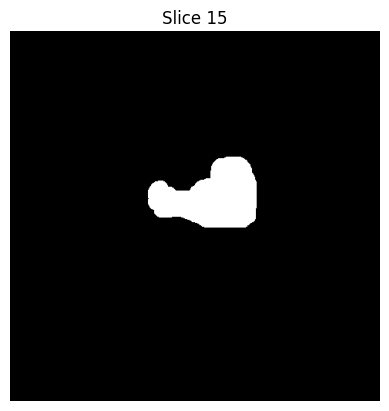

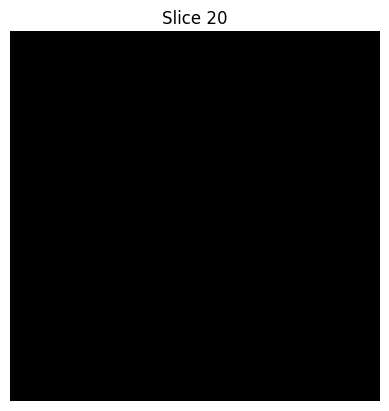

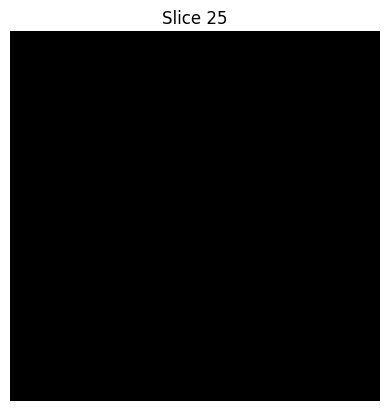

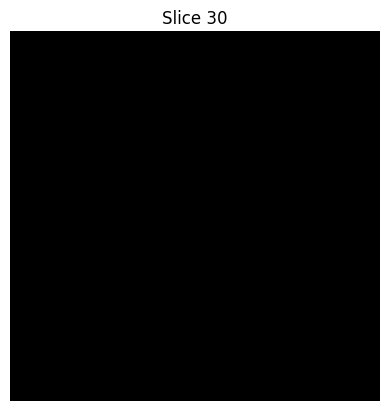

In [5]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img=nib.load("UT-EndoMRI/D1_MHS/D1-000/D1-000_ut_r3.nii.gz")
imgdata=img.get_fdata()

for i in range(0, imgdata.shape[2], 5):  # step of 5 slices
    plt.imshow(imgdata[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

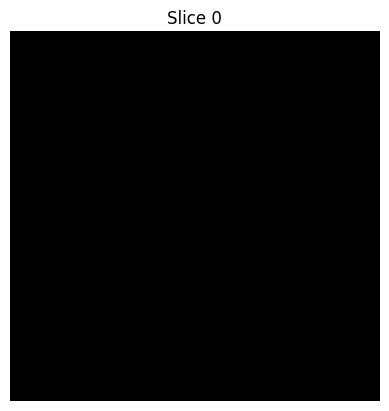

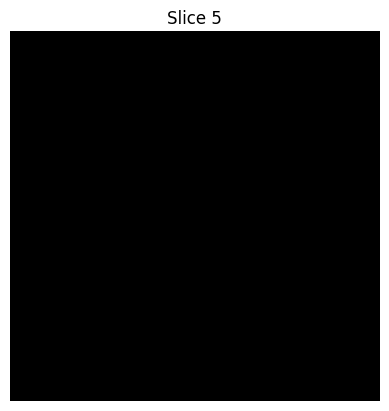

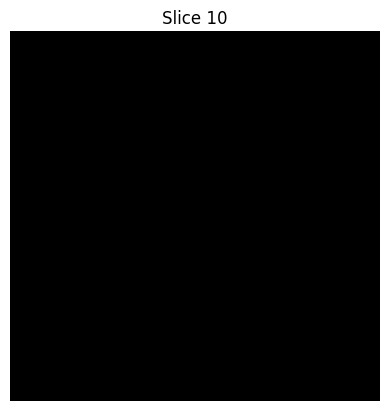

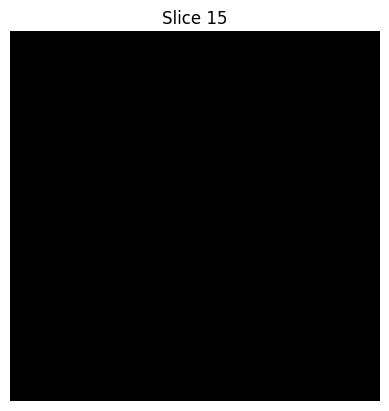

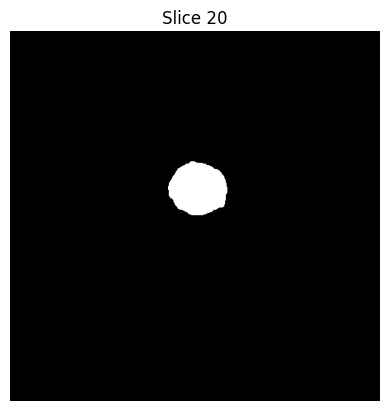

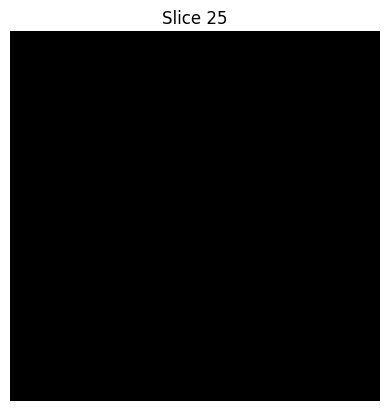

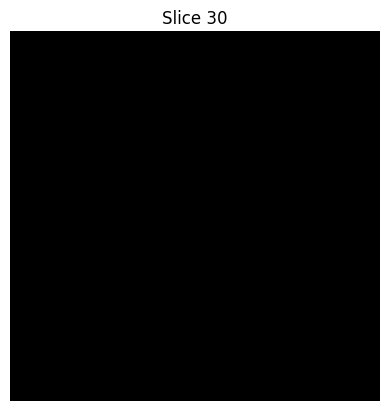

In [6]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img=nib.load("UT-EndoMRI/D1_MHS/D1-000/D1-000_em_r1.nii.gz")
imgdata=img.get_fdata()

for i in range(0, imgdata.shape[2], 5):  # step of 5 slices
    plt.imshow(imgdata[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

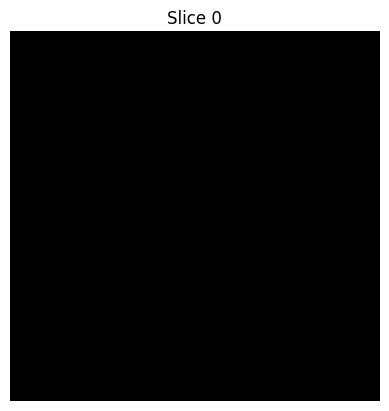

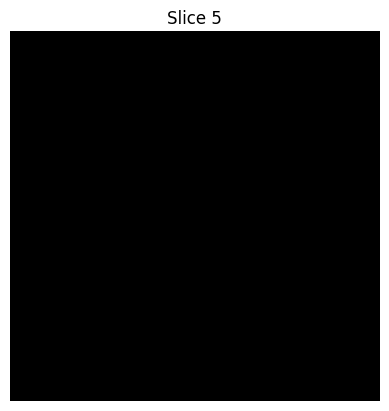

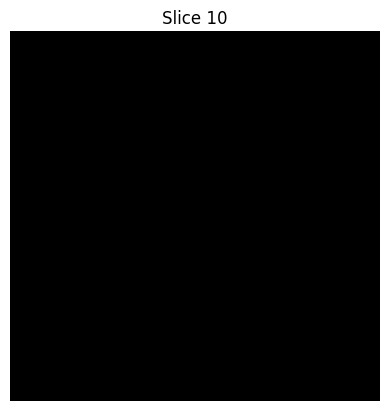

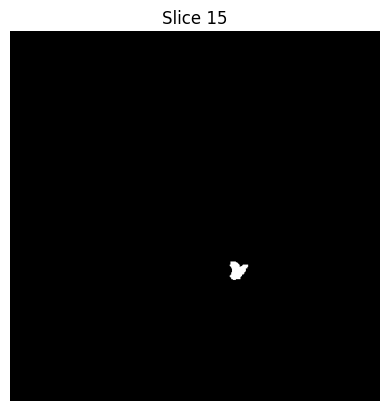

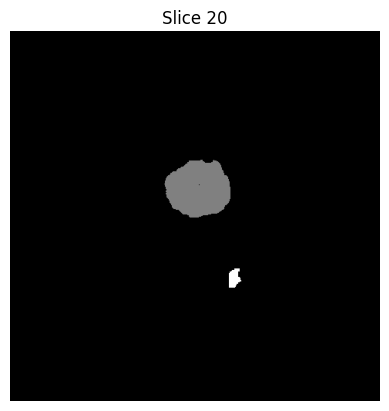

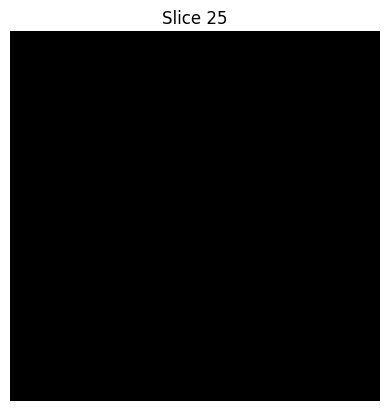

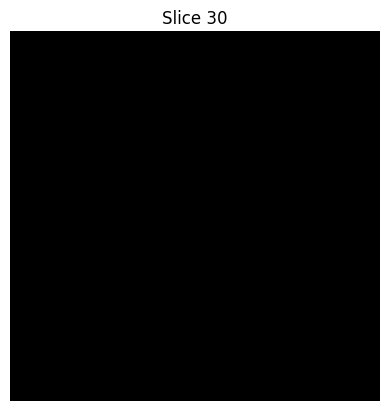

In [7]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img=nib.load("UT-EndoMRI/D1_MHS/D1-000/D1-000_em_r2.nii.gz")
imgdata=img.get_fdata()

for i in range(0, imgdata.shape[2], 5):  # step of 5 slices
    plt.imshow(imgdata[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

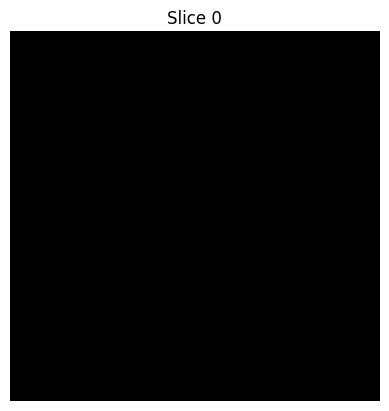

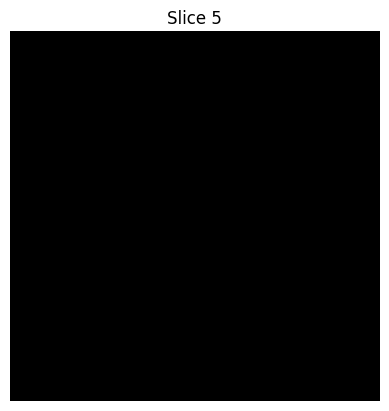

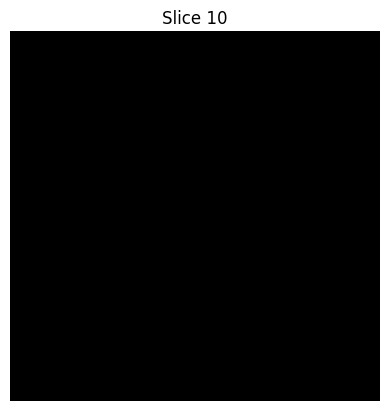

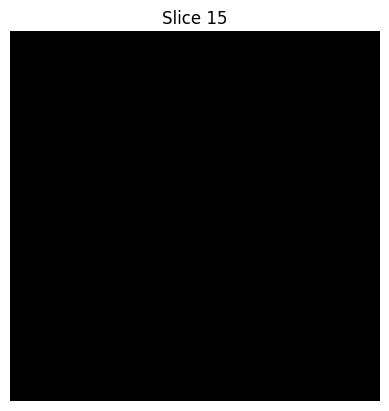

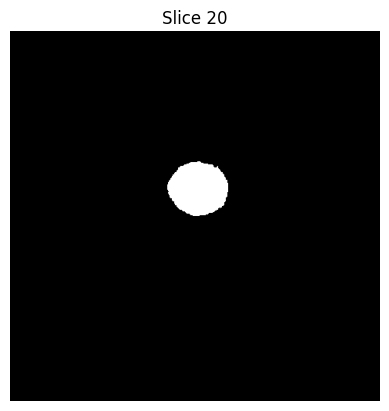

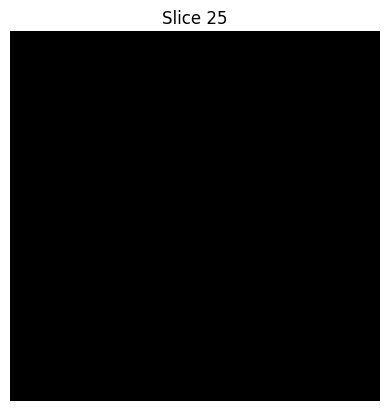

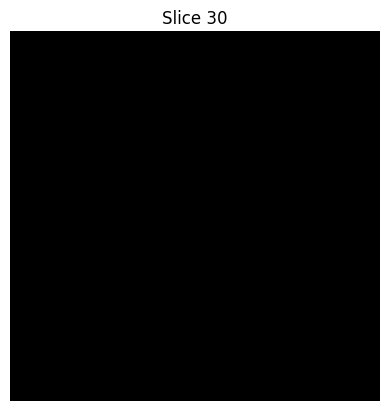

In [8]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

img=nib.load("UT-EndoMRI/D1_MHS/D1-000/D1-000_em_r3.nii.gz")
imgdata=img.get_fdata()

for i in range(0, imgdata.shape[2], 5):  # step of 5 slices
    plt.imshow(imgdata[:, :, i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

The dataset contains images in .nii format which is a 3d MRI scan. Here i used nib library to view the slices of the scan.

There are 5 types of scans:
- ovaries
- uterus
- endometriosacs
- T1 fat saturated scans 
- T2 scans 

uterus and endometriosacs have 3 regions of interest separated through different scans and ovaries scan has one region of interest.